In [1]:
#importing all the packages
import mne 
mne.set_log_level('error')
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy import stats
from mne.stats import permutation_t_test

In [2]:
#setting conditions to be match and mismatch
conditions = ['Match', 'Mismatch']

#reading in evoked data files
data_dir = 'data_out/' 
data_files = glob.glob(data_dir + '*-ave.fif')

print(data_files)

#Creating evoked dictionary with match and mismatch entries 
evoked_dict = {}

for idx, c in enumerate(conditions): 
    evoked_dict[c] = [mne.read_evokeds(d)[idx] for d in data_files]

print(np.sum(evoked_dict['Mismatch'][0]._data == evoked_dict['Mismatch'][1]._data))
print(len(evoked_dict['Match']))

['data_out/l2_13-ave.fif', 'data_out/l2_25-ave.fif', 'data_out/l2_21-ave.fif', 'data_out/l2_24-ave.fif', 'data_out/l2_20-ave.fif', 'data_out/l2_16-ave.fif', 'data_out/l2_22-ave.fif', 'data_out/l2_14-ave.fif', 'data_out/l2_19-ave.fif', 'data_out/l2_23-ave.fif']
0
10


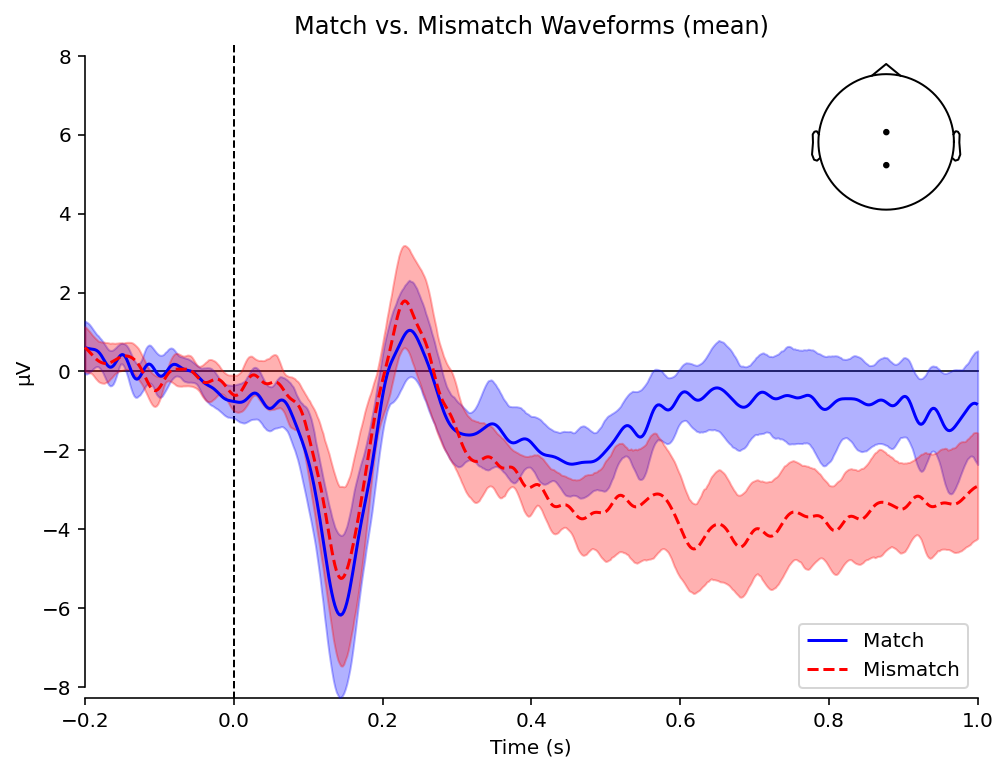

In [3]:
#plotting parameters for average waveforms
electrodes = ['Cz', 'Pz']
color_dict = {'Match':'blue', 'Mismatch':'red'}
line_dict = {'Match':'-', 'Mismatch':'--'}

#Creating average waveform plot
mne.viz.plot_compare_evokeds(evoked_dict,
                             combine='mean',
                             legend='lower right',
                             picks=electrodes, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=line_dict,
                             title='Match vs. Mismatch Waveforms'
                            )

plt.show()

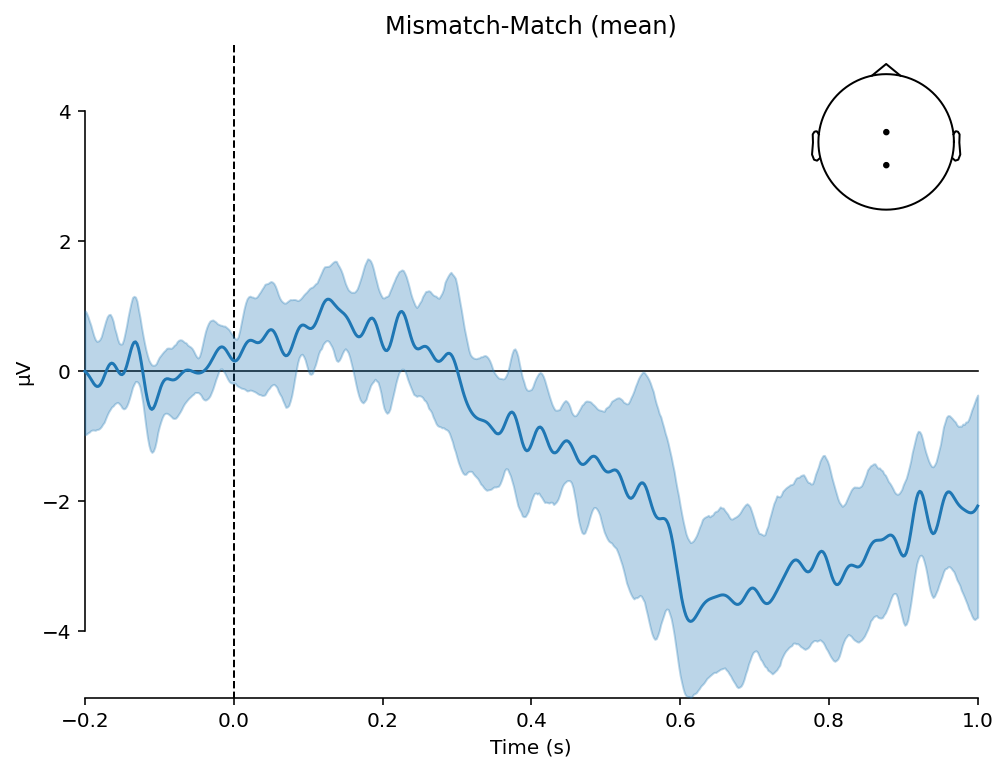

In [4]:
# Mismatch-Match Differences
diff_waves = []

for i in range(len(data_files)): 
    diff_waves.append(mne.combine_evoked([evoked_dict['Mismatch'][i], evoked_dict['Match'][i]],
                                          weights=[1, -1]
                                         )
                     )

# Mismatch-Match plot 

contrast = 'Mismatch-Match'
mne.viz.plot_compare_evokeds({contrast:diff_waves}, combine = 'mean', 
                              legend=None, 
                             picks=electrodes, show_sensors = 'upper right', 
                             title=contrast
                            )
plt.show()

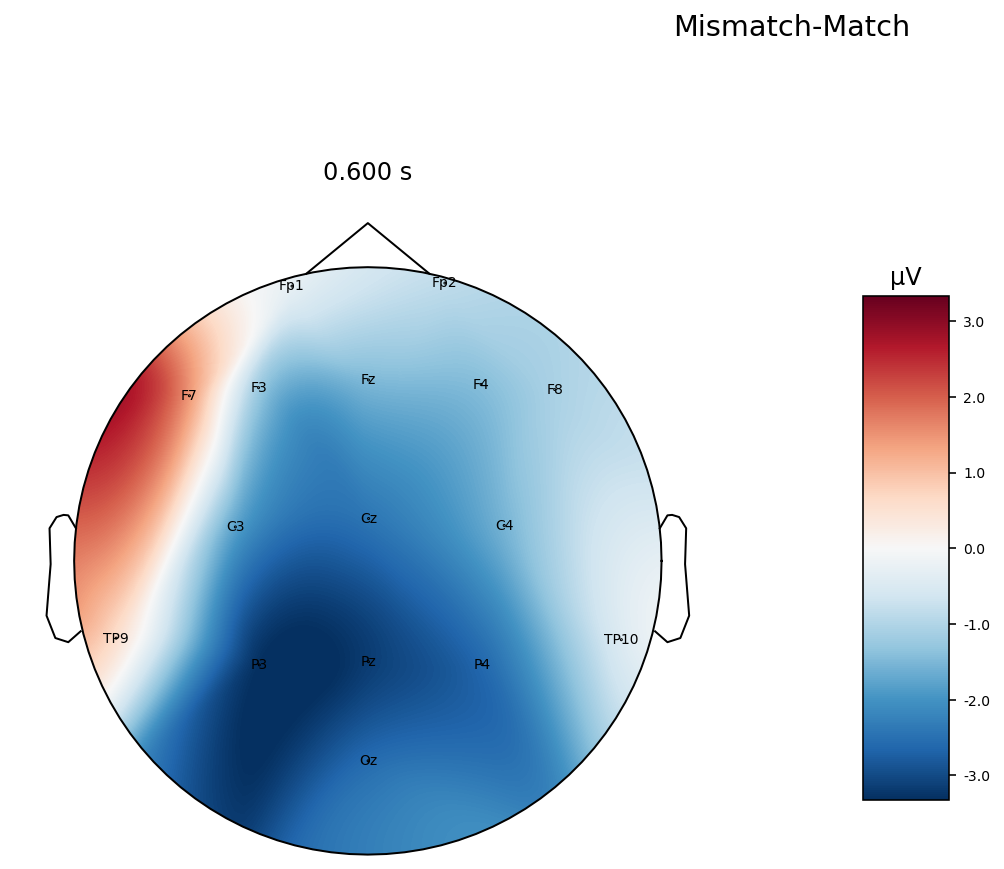

In [5]:
# scalp topographic map plotting 
mne.viz.plot_evoked_topomap(mne.grand_average(diff_waves),
                            times=0.600, average=0.200, 
                            title=contrast,
                            show_names=True,
                            contours=False,
                            size=4
                           )
plt.show()

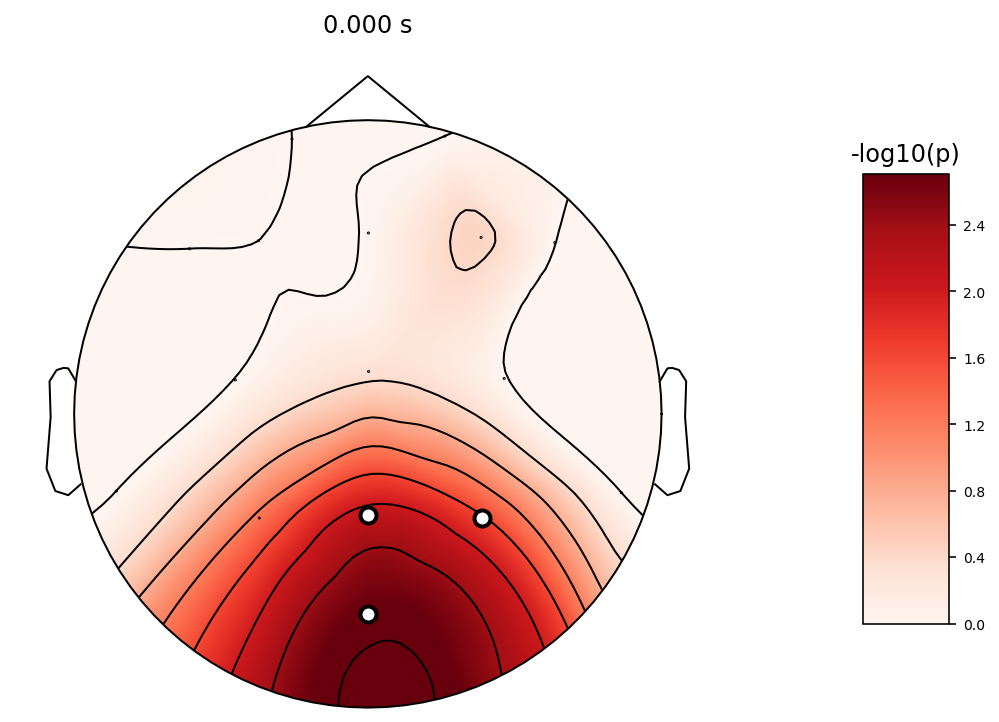

In [7]:
#Permutation t-tests
evoked_data2 = np.array([np.mean(e.get_data(tmin=.400, tmax=.600), axis=1) for e in diff_waves])


n_permutations = 50000
T0, p_values, H0 = permutation_t_test(evoked_data2, n_permutations, tail=-1)

#creating a new evoked set for p-values so we can create topomap
evoked_pval = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis], 
                              evoked_dict[conditions[0]][0].info, tmin= 0.
                             )

# Creating a mask for the topomap 
mask = p_values[:, np.newaxis] <= 0.05

#Creating topomap across electrodes. 

evoked_pval.plot_topomap(times = 0, 
                         scalings = 1, 
                         cmap = 'Reds', 
                         vmin = 0, 
                         units = '-log10(p)', 
                         mask = mask, 
                         size = 4)
plt.show()